In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Sentiment Analysis 

The goal of this project is to analyse the user sentiment towards the US airline industry on twitter using different models from the scikit-learn library.
- the dataset used contains a manually labelled sentiment per tweet : (positive, negative, neutral)

### Loading the libraries needed:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


### Loading and inspecting the dataset

,instance_num,tweet,sentiment
0,1,@JetBlue thank you for incredible customer svc...,positive
1,2,"@united I was well taken care of, thanks. I've...",positive
2,3,"@united Too Late Flight, damage has been done....",negative
3,4,"@USAirways of course! ""Yeah, travel has gotten...",negative
4,5,@united I'm very frustrated and have wasted 2 ...,negative



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   instance_num  4000 non-null   int64 
 1   tweet         4000 non-null   object
 2   sentiment     4000 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.9+ KB


<AxesSubplot:xlabel='sentiment'>

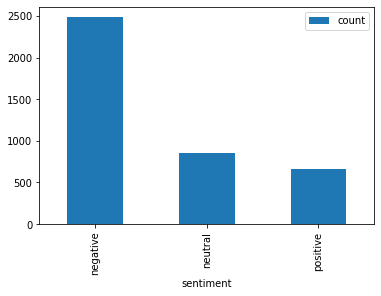

In [4]:
dataset = 'dataset_airlines.tsv'
df_dataset = pd.read_table(dataset, usecols=[0,1,2], names=['instance_num', 'tweet', 'sentiment'], header=None)
df_dataset.head(5)
print('')
#checking the data, checking for Missing Values and the type of data
df_dataset.info(verbose=True)
#checking the distribution of the sentiments, to see if the dataset is balanced
freq_sentiment = pd.crosstab(index=df_dataset['sentiment'], columns='count')
freq_sentiment.plot.bar(y='count')


### Cleaning the tweets.
The tweets must be cleaned due to the special characters. Only strings and the characters: @, # would be mantained in the original tweets. Urls present in a tweet are also deleted

In [5]:
def clean_tweet(tweet_text):
    '''input: unformatted tweets list
       output: formmatted tweets list '''
    
    tweet_text_split = [] 
    for tweet in tweet_text: 
        tweet_text_split.append(tweet.split())

    tweet_text_split_cleaned = [] 
    for i in range(len(tweet_text_split)):
        aux_tweet = []
        for word in tweet_text_split[i]:
            x = re.sub('^https?:\/\/.*[\r\n]*', '', word) #for deleting urls
            x = ''.join(re.findall('[a-zA-Z\#@]',x)) #for only considering letters, @,#
            if len(x) > 1: #len of tweet at least 2
                aux_tweet.append(x)
        tweet_text_split_cleaned.append(aux_tweet)
    tweet_text_formatted = [' '.join(i) for i in tweet_text_split_cleaned]
    return tweet_text_formatted

df_dataset['tweet'] = clean_tweet(df_dataset['tweet'])

### Splitting the dataset into a training and test set

In [6]:
X = df_dataset['tweet'].to_list()
y = df_dataset['sentiment'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(f'The training size is: {len(X_train)} tweets')
print(f'The test size is: {len(X_test)} tweets')


The training size is: 3200 tweets
The test size is: 800 tweets


### Manipulating the tweets
Different functions from the nltk library are tried in order to normalize the words in the tweets

In [7]:
def nltk_normalize(dataset, method):
    '''method: Stemmming or Lemmatization'''
    
    if method == 'Stemming':
        porter = PorterStemmer()
    if method == 'Lemmatization': #default by noun
        lemma = WordNetLemmatizer()
    
    normalized_tweet = []
    for tweet in dataset:
        normalized_sentence = []
        word_tokens = tweet.split()
        for w in word_tokens:
            if method == 'Stemming':
                normalized_sentence.append(porter.stem(w))
            if method == 'Lemmatization':
                normalized_sentence.append(lemma.lemmatize(w))
        normalized_tweet.append(normalized_sentence)
        
    normalized_tweet = [' '.join(i) for i in normalized_tweet]
    return(normalized_tweet)

In [8]:
#applying lemmatization
X_train = nltk_normalize(X_train,'Lemmatization')
X_test = nltk_normalize(X_test,'Lemmatization')


### Vectorizing the tweets.
The sentences of each tweet are transformed into a vector that contains the count of each word of the tweet present in the total bags of words. By doing this encoding , it is possible to train different models

In [9]:
def vectorize_dataset(X_train,X_test, max_features, lowercase=True, token_pattern='[#\@\w]+'):
    vectorize = CountVectorizer(max_features=max_features, lowercase=lowercase, token_pattern=token_pattern) 
    vectorizer_train = vectorize.fit_transform(X_train)
    vectorizer_test = vectorize.transform(X_test)
    return vectorizer_train, vectorizer_test

In [10]:
# create count vectorizer and fit it with training data, from the #example provided
vectorizer_train, vectorizer_test = vectorize_dataset(X_train, X_test,1000)

In [11]:
#example of the first tweet of X_train vectorized into a (1,1000), where 1000 is the max_features (the 1000 most frequent words in X_train)
vectorizer_train[0].shape

(1, 1000)

### Training different models
Models that are going to be tested: **Decision Tree**, **Multinomial Naive Bayes** and **Compliment Naive Bayes**
- **Decision Tree** is a common model used for classification that normally works correctly
- **Multinomial Naive Bayes** is a model normally used for text classification
- **The Compliment Naive Bayes** is a model that is used when a dataset is unbalance. This is normal to happen in sentiment analysis

In [12]:
def model_predict(model, X_test, y_test):
    predicted_y = model.predict(X_test)
    #print(model.predict_proba(X_test))
    print(classification_report(y_test, predicted_y,zero_division=0))
    #print(confusion_matrix(y_test, predicted_y))

In [13]:
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB, ComplementNB

def check_models(X_train,X_test,y_train,y_test, models_tested):
    for model in models_tested:
        print(f'Classification report for the model: {model}')
        if model == 'DT':
            selection = tree.DecisionTreeClassifier(min_samples_leaf=0.01,criterion='entropy',random_state=0)
                    
        if model == 'MNB':
            selection = MultinomialNB()
        
        if model == 'CNB':
            selection = ComplementNB()
            
        model = selection.fit(X_train, y_train)
        model_predict(model, X_test, y_test)
        print('')
        

In [14]:
models_tested = ['DT', 'MNB', 'CNB']
check_models(vectorizer_train, vectorizer_test, y_train, y_test, models_tested)

Classification report for the model: DT
              precision    recall  f1-score   support

    negative       0.73      0.93      0.82       492
     neutral       0.47      0.25      0.33       160
    positive       0.74      0.45      0.56       148

    accuracy                           0.70       800
   macro avg       0.65      0.54      0.57       800
weighted avg       0.68      0.70      0.67       800


Classification report for the model: MNB
              precision    recall  f1-score   support

    negative       0.81      0.88      0.84       492
     neutral       0.60      0.51      0.55       160
    positive       0.70      0.59      0.64       148

    accuracy                           0.76       800
   macro avg       0.70      0.66      0.68       800
weighted avg       0.75      0.76      0.75       800


Classification report for the model: CNB
              precision    recall  f1-score   support

    negative       0.85      0.83      0.84       492
     